# Construction of eulerian comparison point dataframe WEIGHTED by the number of observations
- from L2 filtered data and field interpolation
- create a vaex.dataframe where each row is a point of comparison: 
- compute mean of relative amelioration and not relative amelioration of mean
['id',
 'time',
 'lat',
 'lon',
 'u_drifter',
 'v_drifter',
 'u_geo_swot',
 'v_geo_swot',
 'u_var_swot',
 'v_var_swot',
 'u_geo_nadir',
 'v_geo_nadir',
 'u_var_nadir',
 'v_var_nadir']

In [1]:
import os
import sys
from glob import glob

import cartopy.geodesic as geod
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import numpy as np
import xarray as xr
import vaex
import pandas as pd

import clouddrift as cd

sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt


path_data = '../save_data/eulerian_dataframes/'
path_save_plot = '../save_plots/save_plots_2024-06-25_Eulerian_comparison_weighted'

bbox_drifters = [0, 13.5, 36.5, 44]

#### utils

In [2]:

def plot2d(lon, lat, data, bbox: tuple=bbox_drifters, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)

    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)

    # Add a color bar to show the density scale
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')


    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

In [3]:
def create_luminosity_colormap():
    """
    Create a custom colormap based on luminosity levels.
    
    Returns:
    matplotlib.colors.LinearSegmentedColormap: Custom luminosity colormap.
    """
    colors = [(i / 256.0, i / 256.0, i / 256.0) for i in range(256)]
    luminosity_colormap = matplotlib.colors.LinearSegmentedColormap.from_list("luminosity_colormap", colors, N=256)
    return luminosity_colormap



def plot2d_weighted(lon, lat, data, plot_density=True, n_obs=None, bbox: tuple=bbox_drifters, cmap='Oranges', center_bar=False, fraction_cbar=0.033,  title= None, save_name=None):
    
    # Set up the figure and map projection
    fig = plt.figure(tight_layout=True, figsize=(8, 8))
    crs = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    _ = ax.gridlines(draw_labels=True,)

    # Add land feature for better visualization
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    # Set the map extent
    ax.set_extent(bbox, crs=crs)

    # Plot the density of points
    if center_bar:
        vmax = np.nanmax(np.abs(data))
        vmin = - vmax
    else:
        vmax = np.nanmax(data)
        vmin = np.nanmin(data)

    # 2D data
    mesh = ax.pcolormesh(lon, lat, data, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', fraction=fraction_cbar, pad=0.08)
    #cbar.set_label('Density')

    if plot_density:
        # plot density of observations with luminosity
        luminosity_grid = n_obs
        luminosity_colormap = create_luminosity_colormap()
        obs = ax.contour(lon, lat, luminosity_grid, levels=np.array([400, 800, 1200, 1600, 2000, 2400, 2800])*0.5, transform=crs, cmap=luminosity_colormap, alpha=0.2)
        #ax.colorbar(label='Number of Observations', orientation='horizontal')
        cbar2 = plt.colorbar(obs, label='Number of Observations', ax=ax, orientation='horizontal', pad=0.08)

    if title:
        ax.set_title(title)
        
    ### SAVE
    if save_name:
        ax.set_title(save_name)
        save_name = save_name
        plt.savefig(os.path.join(path_save_plot,save_name), bbox_inches='tight', dpi = 300)

## Eulerian comparison

#### data processing

In [4]:
#open dataframe
df_raw = vaex.open(os.path.join(path_data, 'L4_and_lowess_30min_vs01_final_filter_SVPonly.hdf5'))

print('Number of observations : ', len(df_raw))

df = df_raw

select_domain = False
if select_domain:
    trace_domain = (3, 6, 37.5, 43.5)
    lon_min, lon_max, lat_min, lat_max = trace_domain
    df = vaex.from_pandas(df_raw[(df_raw['lat'] >= lat_min) & (df_raw['lat'] <= lat_max) & (df_raw['lon'] >= lon_min) & (df_raw['lon'] <= lon_max)])

    print('Number of observations selected : ', len(df))

df[:3]

Number of observations :  278342


#,id,time,lat,lon,u_drifter,v_drifter,u_geo_swot,v_geo_swot,u_var_swot,v_var_swot,u_geo_nadir,v_geo_nadir,u_var_nadir,v_var_nadir
0,300534061395960,2023-05-04 20:30:00.000000000,40.8596,4.92756,0.0453329,0.092028,0.0519416,0.021194,0.0570241,0.0294574,0.0664307,0.00931008,0.0714132,0.0141187
1,300534061395960,2023-05-04 21:00:00.000000000,40.8673,4.92856,0.0453765,0.0982447,0.0597697,0.0183892,0.0655016,0.0265522,0.071838,0.00641901,0.0770312,0.0111136
2,300534061395960,2023-05-04 21:30:00.000000000,40.8675,4.92868,0.0454667,0.104298,0.0596196,0.0183783,0.0653389,0.0265461,0.0719427,0.00635922,0.0771492,0.011061


In [5]:
# compute metrics
df['L2_norm_geoswot'] = np.sqrt( (df.u_geo_swot - df.u_drifter)**2 + (df.v_geo_swot - df.v_drifter)**2)
df['L2_norm_varswot'] = np.sqrt( (df.u_var_swot - df.u_drifter)**2 + (df.v_var_swot - df.v_drifter)**2)
df['L2_norm_geonadir'] = np.sqrt( (df.u_geo_nadir - df.u_drifter)**2 + (df.v_geo_nadir - df.v_drifter)**2)
df['L2_norm_varnadir'] = np.sqrt( (df.u_var_nadir - df.u_drifter)**2 + (df.v_var_nadir - df.v_drifter)**2)

# compa drifter/satellite
df['swotnadircyclo_rel_amelioration'] = (df['L2_norm_varswot'] - df['L2_norm_varnadir']) / df['L2_norm_varnadir'] 
df['swotnadirgeo_rel_amelioration'] = (df['L2_norm_geoswot'] - df['L2_norm_geonadir']) / df['L2_norm_geonadir'] 

# direct compa satellite
df['L2_norm_swotnadir_geo'] = np.sqrt( (df.u_geo_swot - df.u_geo_nadir)**2 + (df.v_geo_swot - df.v_geo_nadir)**2)
df['L2_norm_swotnadir_cyclo'] = np.sqrt( (df.u_var_swot - df.u_var_nadir)**2 + (df.v_var_swot - df.v_var_nadir)**2)

# angle & mag drifter/satellite
U_drifter = df.u_drifter.values + 1j * df.v_drifter.values

U_geoswot = df.u_geo_swot.values + 1j * df.v_geo_swot.values
U_varswot = df.u_var_swot.values + 1j * df.v_var_swot.values
U_geonadir = df.u_geo_nadir.values + 1j * df.v_geo_nadir.values
U_varnadir = df.u_var_nadir.values + 1j * df.v_var_nadir.values

df['diffarg_geoswot'] = np.angle(U_geoswot) - np.angle(U_drifter) 
df['diffarg_varswot'] = np.angle(U_varswot) - np.angle(U_drifter) 
df['diffarg_geonadir'] = np.angle(U_geonadir) - np.angle(U_drifter) 
df['diffarg_varnadir'] = np.angle(U_varnadir) - np.angle(U_drifter) 

df['diffabs_geoswot'] = np.abs(U_geoswot) - np.abs(U_drifter) 
df['diffabs_varswot'] = np.abs(U_varswot) - np.abs(U_drifter) 
df['diffabs_geonadir'] = np.abs(U_geonadir) - np.abs(U_drifter) 
df['diffabs_varnadir'] = np.abs(U_varnadir) - np.abs(U_drifter) 


In [52]:
# defines the grid to apply statistics
resolution = 0.15 #°
lon_grid = np.arange(df.lon.min(), df.lon.max(), resolution)
lat_grid = np.arange(df.lat.min(), df.lat.max(), resolution)

n_lat, n_lon = lat_grid.shape[0], lon_grid.shape[0]
print('resolution : ', resolution, '\ngrid shape (lat, lon): ', n_lat, n_lon)


# Compute the means on the grid
columns_to_mean = df.column_names[4:]
mean_grid = {col: df.mean(df[col], binby=[df['lon'], df['lat']], shape=(n_lon, n_lat)).T for col in columns_to_mean}

resolution :  0.15 
grid shape (lat, lon):  63 122


In [7]:
#define the indexes of the grid that are under the swath of SWOT
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

swath_idx = isin_swath(lon_mesh, lat_mesh)
swath_idx.shape

(63, 122)

## Plots

In [58]:
DENSITY, lat_edges, lon_edges = np.histogram2d(df.lat.values, df.lon.values, bins=(n_lat, n_lon), range=None, density=False)

In [8]:
plot2d(lon_edges, lat_edges, DENSITY, title='Histogram of the eulerian comparison points')

### Compa field/drifter : Velocities L2 norm ### means grid after compa

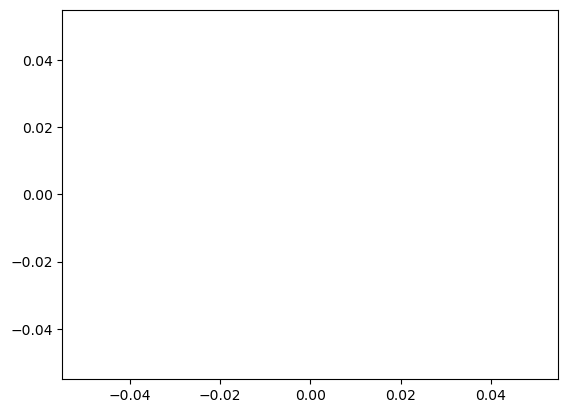

In [44]:
data_raw = mean_grid['swotnadircyclo_rel_amelioration']
data, density = remove_outliers(data_raw, DENSITY, zscore=4)

hist, bins, _ = plt.hist( data.flatten(), weights=density.flatten(), bins=30)

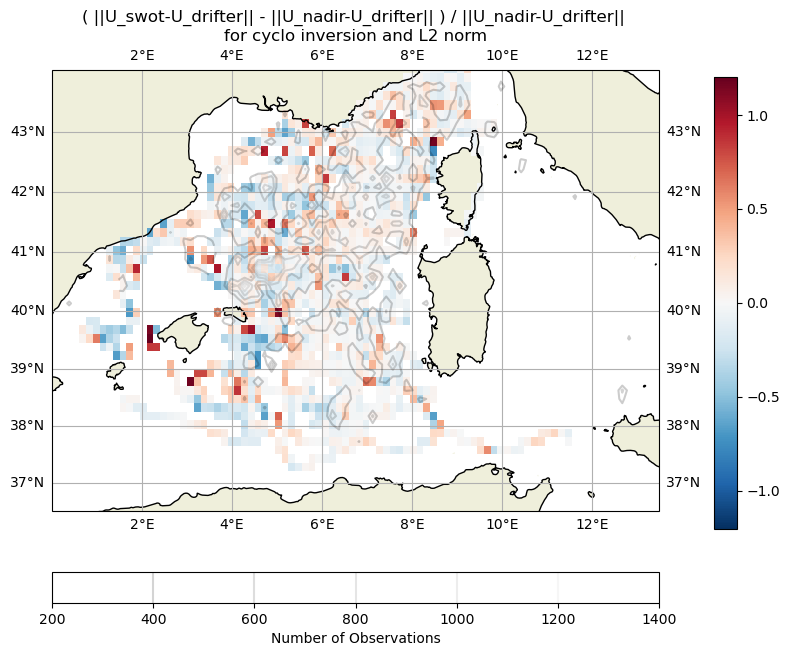

In [46]:
plot2d_weighted(lon_grid, lat_grid, data, n_obs=density, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

### Compa field/drifter : Velocities L2 norm ### means grid before compa

raw data (without z>3)

import copy

def eulerian_compa(data, density, window_idx=None, zscore=3, zscore2=None):
    _data = copy.deepcopy(data)
    _density = copy.deepcopy(density)
    
    if window_idx:
        _data[window_idx] = np.nan
        _density[window_idx] = np.nan
    
    _data, _density = remove_outliers(_data, _density, zscore)
    if zscore2:
        _data, _density = remove_outliers(_data, _density, zscore2)
    
    esperance = np.nansum(_data * _density / np.nansum(_density))

    return _data, _density, esperance

In [59]:



def eulerian_compa(data, density, window_idx=None, zscore=3, zscore2=None):
    _data = copy.deepcopy(data)
    _density = copy.deepcopy(density)
    
    if window_idx:
        _data[window_idx] = np.nan
        _density[window_idx] = np.nan
    
    _data, _density = remove_outliers(_data, _density, zscore)
    if zscore2:
        _data, _density = remove_outliers(_data, _density, zscore2)
    
    esperance = np.nansum(_data * _density / np.nansum(_density))

    return _data, _density, esperance

In [89]:
data = (mean_grid['L2_norm_varswot'] - mean_grid['L2_norm_varnadir']) / mean_grid['L2_norm_varnadir']

data, density, esp = eulerian_compa(data, DENSITY, zscore=3, zscore2=2)
esp

-0.02833002406843427

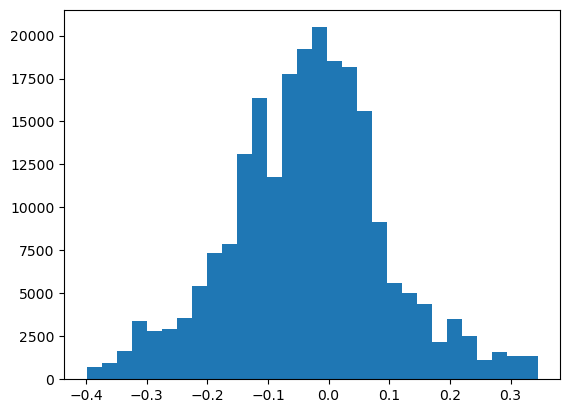

In [88]:
hist, bins, _ = plt.hist( data.flatten(), weights=density.flatten(), bins=30)

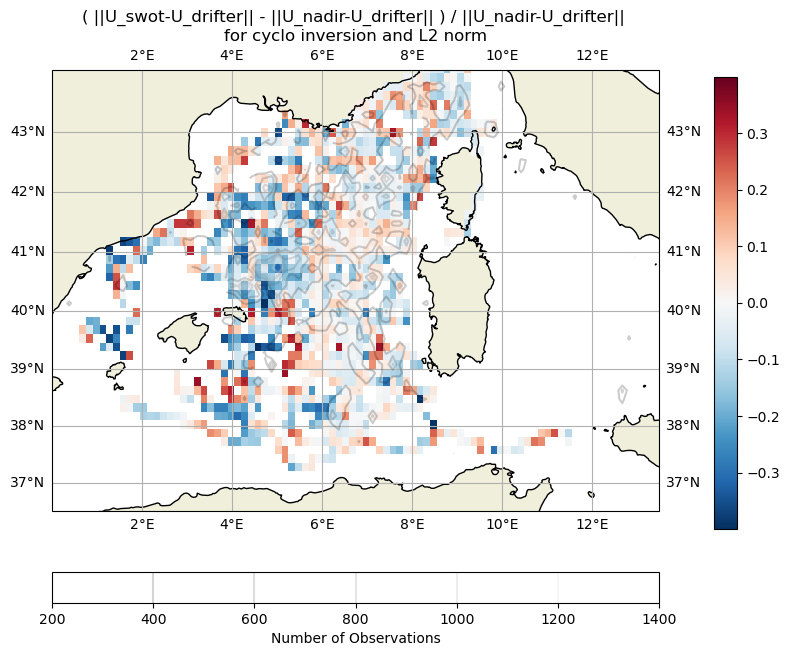

In [90]:
#plot2d(lon_grid, lat_grid, mean_grid['L2_norm_varswot'])
#plot2d(lon_grid, lat_grid, mean_grid['L2_norm_varnadir'])

plot2d_weighted(lon_grid, lat_grid, data, n_obs=density, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

only inside the swath

In [17]:
data = (mean_grid['L2_norm_varswot'] - mean_grid['L2_norm_varnadir']) / mean_grid['L2_norm_varnadir']

data[~swath_idx] = np.nan
density[~swath_idx] = np.nan

data, density = remove_outliers(data, DENSITY, 2)

esperance = np.nansum(data * density / np.nansum(density))
print('esperance =', esperance)

esperance = -0.10558807811117467


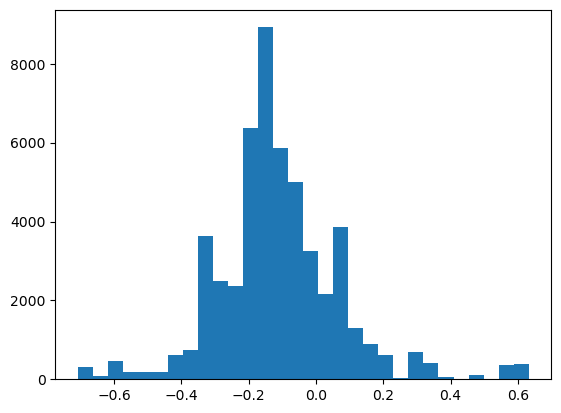

In [18]:
hist, bins, _ = plt.hist( data.flatten(), weights=density.flatten(), bins=30)

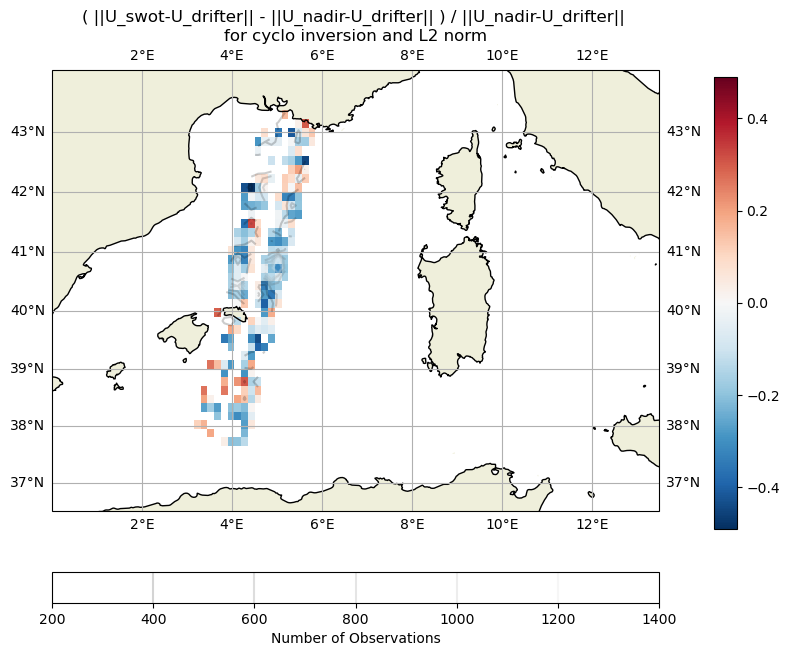

In [36]:
plot2d_weighted(lon_grid, lat_grid, data, plot_density=True, n_obs=density, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

where density > 800

In [42]:
square = (4 <= lon_mesh) & (lon_mesh <= 7) & (39.5 <= lat_mesh) & (lat_mesh <= 41.5)
high_density_idx = ~np.logical_and(square, DENSITY>1200)

In [46]:
data = (mean_grid['L2_norm_varswot'] - mean_grid['L2_norm_varnadir']) / mean_grid['L2_norm_varnadir']
data, density = remove_outliers(data, DENSITY, 3)

data[~high_density_idx] = np.nan
density[~high_density_idx] = np.nan

data, density = remove_outliers(data, density, 3)

esperance = np.nansum(data * density / np.nansum(density))
print('esperance =', esperance)

esperance = -0.07392503926388844


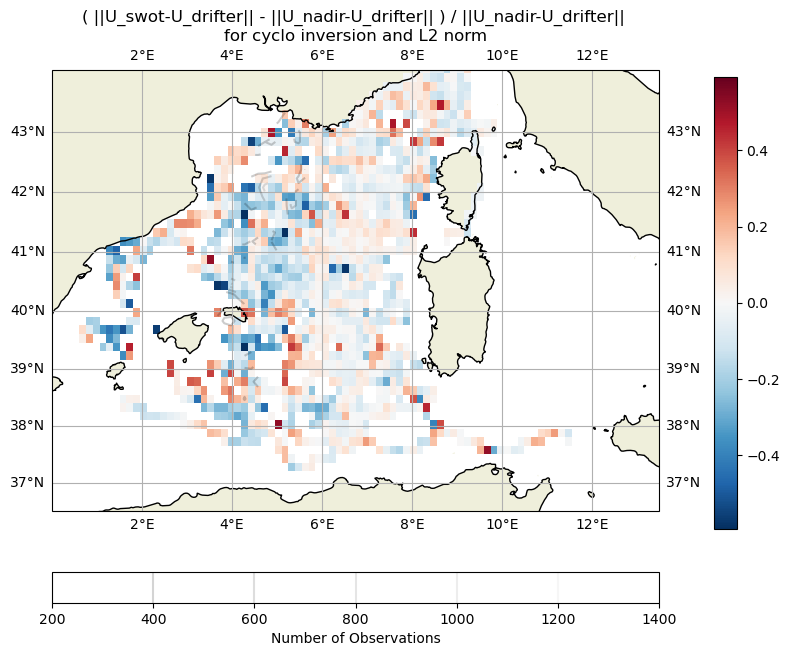

In [47]:
plot2d_weighted(lon_grid, lat_grid, data, plot_density=True, n_obs=density, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

esperance = -0.06938462662019075


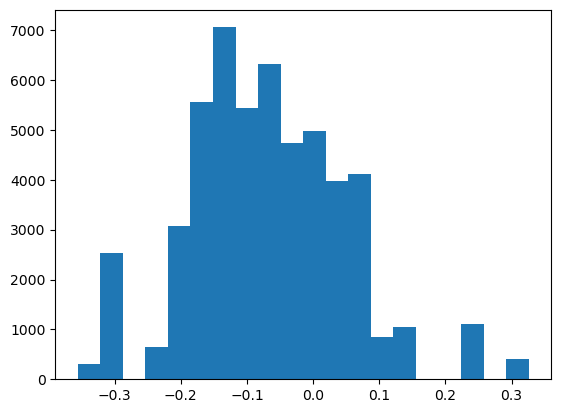

In [58]:
hist, bins, _ = plt.hist( compa_select.flatten(), weights=density_select.flatten(), bins=20)

esperance = np.nansum(compa_select * density_select / np.nansum(density_select))
print('esperance =', esperance)

swath + many observations

In [78]:
select = np.logical_or(~swath_idx, density_wo<200)

compa_select = compa_norma_wo.copy()
compa_select[select] = np.nan

density_select = density_wo.copy()
density_select[select] = np.nan

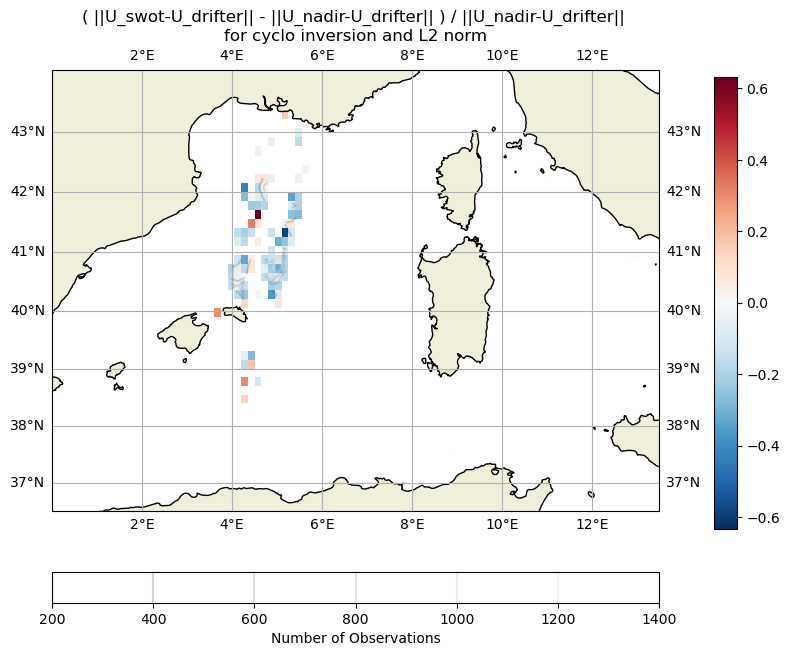

In [79]:
plot2d_weighted(lon_grid, lat_grid, compa_select, plot_density=True, n_obs=density_select, cmap='RdBu_r', center_bar=True, title='( ||U_swot-U_drifter|| - ||U_nadir-U_drifter|| ) / ||U_nadir-U_drifter|| \nfor cyclo inversion and L2 norm')  

In [80]:
compa_select, density_select = remove_outliers(compa_select, density_select, 2)

esperance = -0.11967166454102861


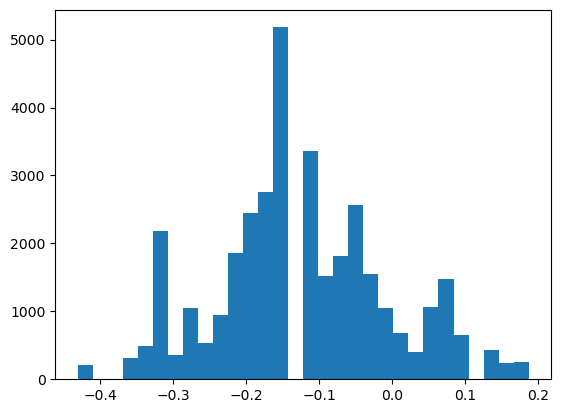

In [81]:
hist, bins, _ = plt.hist( compa_select.flatten(), weights=density_select.flatten(), bins=30)

esperance = np.nansum(compa_select * density_select / np.nansum(density_select))
print('esperance =', esperance)

### Direct compa norm(swot-nadir)

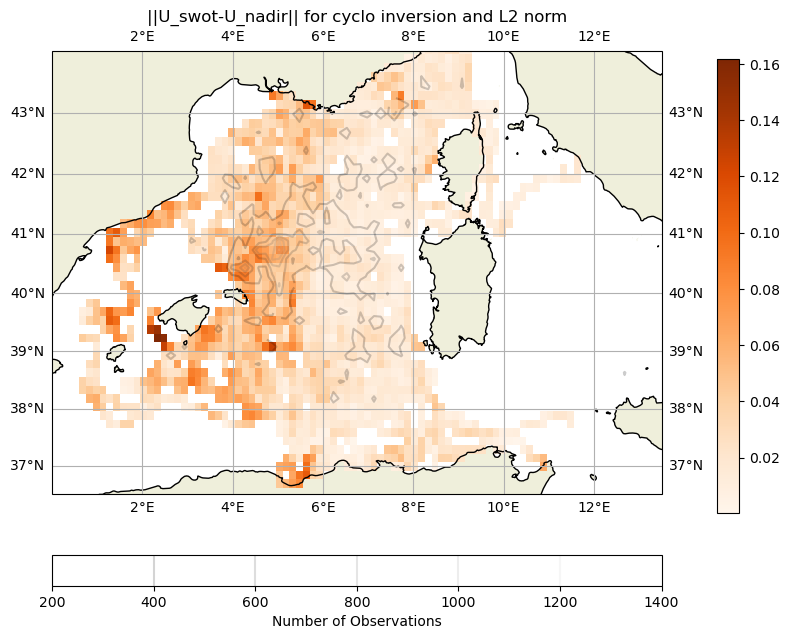

In [41]:
data = mean_grid['L2_norm_swotnadir_geo']

plot2d_weighted(lon_grid, lat_grid, data, plot_density=True, n_obs=density, cmap='Oranges', center_bar=False, title='||U_swot-U_nadir|| for cyclo inversion and L2 norm')  

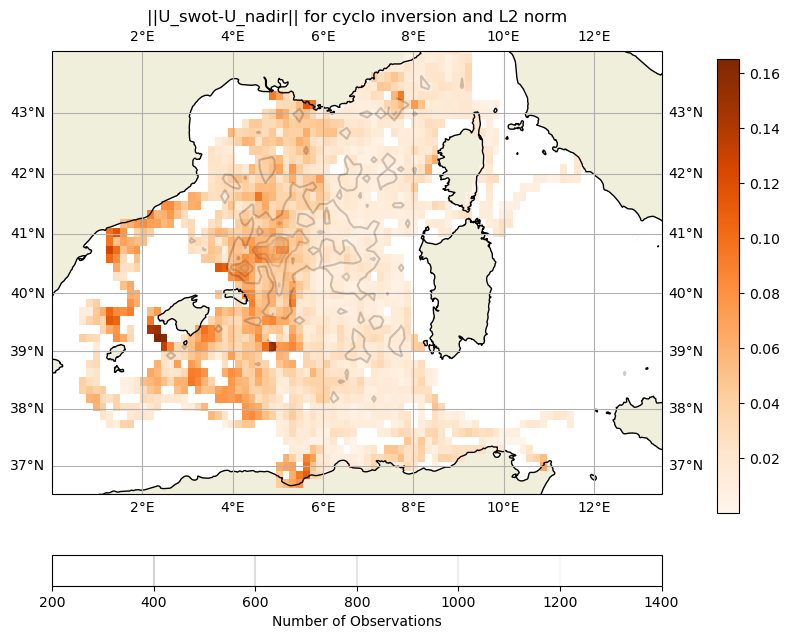

In [42]:
data = mean_grid['L2_norm_swotnadir_cyclo']

plot2d_weighted(lon_grid, lat_grid, data, plot_density=True, n_obs=density, cmap='Oranges', center_bar=False, title='||U_swot-U_nadir|| for cyclo inversion and L2 norm')  

### angle between drifters and geostrophie

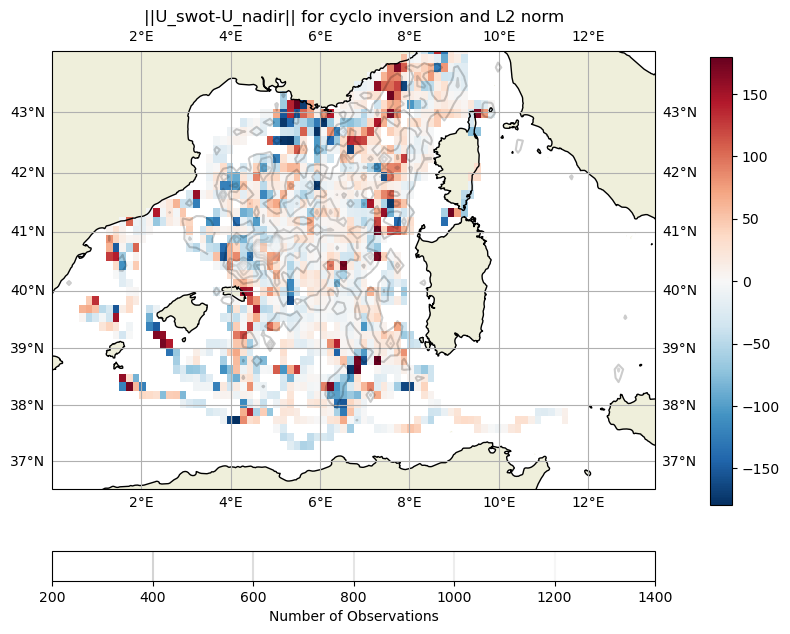

In [82]:
data = normalize_angle(mean_grid['diffarg_varswot']*180/np.pi)

plot2d_weighted(lon_grid, lat_grid, data, plot_density=True, n_obs=density, cmap='RdBu_r', center_bar=True, title='||U_swot-U_nadir|| for cyclo inversion and L2 norm')  

In [83]:
esperance = np.nansum(data * density / np.nansum(density))
print('esperance =', esperance)

esperance = 0.2988658837567937


In [16]:
mean_grid['diffarg_geoswot']

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])